This notebook visualizes and compares an LSM variable from two restart files.  
Users should specify the two NWM restart file paths `file_RST1` and `file_RST2`, and the variable name `Var`.

In [32]:
file_RST1 = '/glade/work/enzminger/jtti-snow-filter/domain/upper_colorado/taylor_park/v2.1/NWM/RESTART_spinup_2007-10-01_v2.1_AORC/RESTART.2016100100_DOMAIN1'
file_RST2 = '/glade/work/enzminger/jtti-snow-filter/domain/upper_colorado/taylor_park/v2.1/NWM/RESTART_spinup_2007-10-01_v2.1_AORC/RESTART.2017010100_DOMAIN1'
Var = 'SNICE'

See below for a detailed description of snow-related variables within NWM restart files

<table style="width:100%">
  <tr>

        
        
| Variable name | dimension | Long Name | Prognostic / Diagnostic |
|---------------|-----------|-----------|-------------------------|
| SNEQV | (Time, south_north, west_east) | bulk snow water equivalent | prognostic in zero-layer mode, otherwise assumed to equal the sum of SNLIQ[ISNOW+1:0] + SNICE[ISNOW+1:0] |
| SNOWH | (Time, south_north, west_east) | bulk snow depth | prognostic in zero-layer mode, otherwise assumed to equal the sum of ZSNSO[ISNOW+1:0] |
| ISNOW | (Time, south_north, west_east) | number of active snow layers * -1 | prognostic |
| SNICE | (Time, south_north, snow_layers, west_east) | layer snow ice content | prognostic when ISNOW < 0 |
| SNLIQ | (Time, south_north, snow_layers, west_east) | layer snow liquid content | prognostic when ISNOW < 0 |
| ZSNSO | (Time, south_north, sosn_layers, west_east) | layer depth from (air) surface, including soil layers | ?prognostic for snow when ISNOW<0? |
| SNEQVO| (Time, south_north, west_east) | previous bulk snow water equivalent | prognostic when using BATS albedo |
| ALBOLD| (Time, south_north, west_east) | previous albedo | prognostic for CLASS albedo scheme |
                

  </tr>
</table>
        


#### Loading Modules

In [33]:
%%time
## Load conda environment >> conda activate /glade/work/mazrooei/miniconda3/envs/myxr
import sys
from datetime import datetime
import glob
import time
import pathlib
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt

CPU times: user 17 µs, sys: 5 µs, total: 22 µs
Wall time: 25.3 µs



#### Opening datasets

In [83]:
%%time
def preprocess_rst(ds):
    ds = ds.drop_vars(set(ds.data_vars).difference(set([Var])))
    return ds
print('Opening',file_RST1)
ds_rst1 = xr.open_mfdataset(file_RST1, preprocess=preprocess_rst)
display(ds_rst1)
print(100*'_')
print('Opening',file_RST2)
ds_rst2 = xr.open_mfdataset(file_RST2, preprocess=preprocess_rst)
display(ds_rst2)

Opening /glade/work/enzminger/jtti-snow-filter/domain/upper_colorado/taylor_park/v2.1/NWM/RESTART_spinup_2007-10-01_v2.1_AORC/RESTART.2016100100_DOMAIN1


<xarray.Dataset>
Dimensions:  (Time: 1, snow_layers: 3, south_north: 24, west_east: 30)
Dimensions without coordinates: Time, snow_layers, south_north, west_east
Data variables:
    SNOW_T   (Time, south_north, snow_layers, west_east) float32 dask.array<chunksize=(1, 24, 3, 30), meta=np.ndarray>
Attributes:
    TITLE:          RESTART FILE FROM HRLDAS v20150506
    missing_value:  -1e+33
    START_DATE:     2007-10-01_00:00:00
    MAP_PROJ:       1
    LAT1:           38.83563
    LON1:           -106.78017
    DX:             1000.0
    DY:             1000.0
    TRUELAT1:       30.0
    TRUELAT2:       60.0
    STAND_LON:      -97.0
    MMINLU:         USGS

____________________________________________________________________________________________________
Opening /glade/work/enzminger/jtti-snow-filter/domain/upper_colorado/taylor_park/v2.1/NWM/RESTART_spinup_2007-10-01_v2.1_AORC/RESTART.2017010100_DOMAIN1


<xarray.Dataset>
Dimensions:  (Time: 1, snow_layers: 3, south_north: 24, west_east: 30)
Dimensions without coordinates: Time, snow_layers, south_north, west_east
Data variables:
    SNOW_T   (Time, south_north, snow_layers, west_east) float32 dask.array<chunksize=(1, 24, 3, 30), meta=np.ndarray>
Attributes:
    TITLE:          RESTART FILE FROM HRLDAS v20150506
    missing_value:  -1e+33
    START_DATE:     2007-10-01_00:00:00
    MAP_PROJ:       1
    LAT1:           38.83563
    LON1:           -106.78017
    DX:             1000.0
    DY:             1000.0
    TRUELAT1:       30.0
    TRUELAT2:       60.0
    STAND_LON:      -97.0
    MMINLU:         USGS

CPU times: user 55.3 ms, sys: 1.93 ms, total: 57.2 ms
Wall time: 63.2 ms



#### plotting Var

In [84]:
var1 = ds_rst1[Var]
var2 = ds_rst2[Var]
name1 = pathlib.Path(var1.encoding["source"]).name.replace('_DOMAIN1','').replace('RESTART.','RST_')
name2 = pathlib.Path(var2.encoding["source"]).name.replace('_DOMAIN1','').replace('RESTART.','RST_')

plot_dims = [v for v in var1.dims if v not in ['south_north', 'west_east'] ]
if len(plot_dims)>1:
    plot_dims.remove('Time')
print(plot_dims)
plot_dims_sizes = [var1.sizes[d] for d in plot_dims]
print(plot_dims_sizes)

['snow_layers']
[3]


CPU times: user 709 ms, sys: 0 ns, total: 709 ms
Wall time: 713 ms


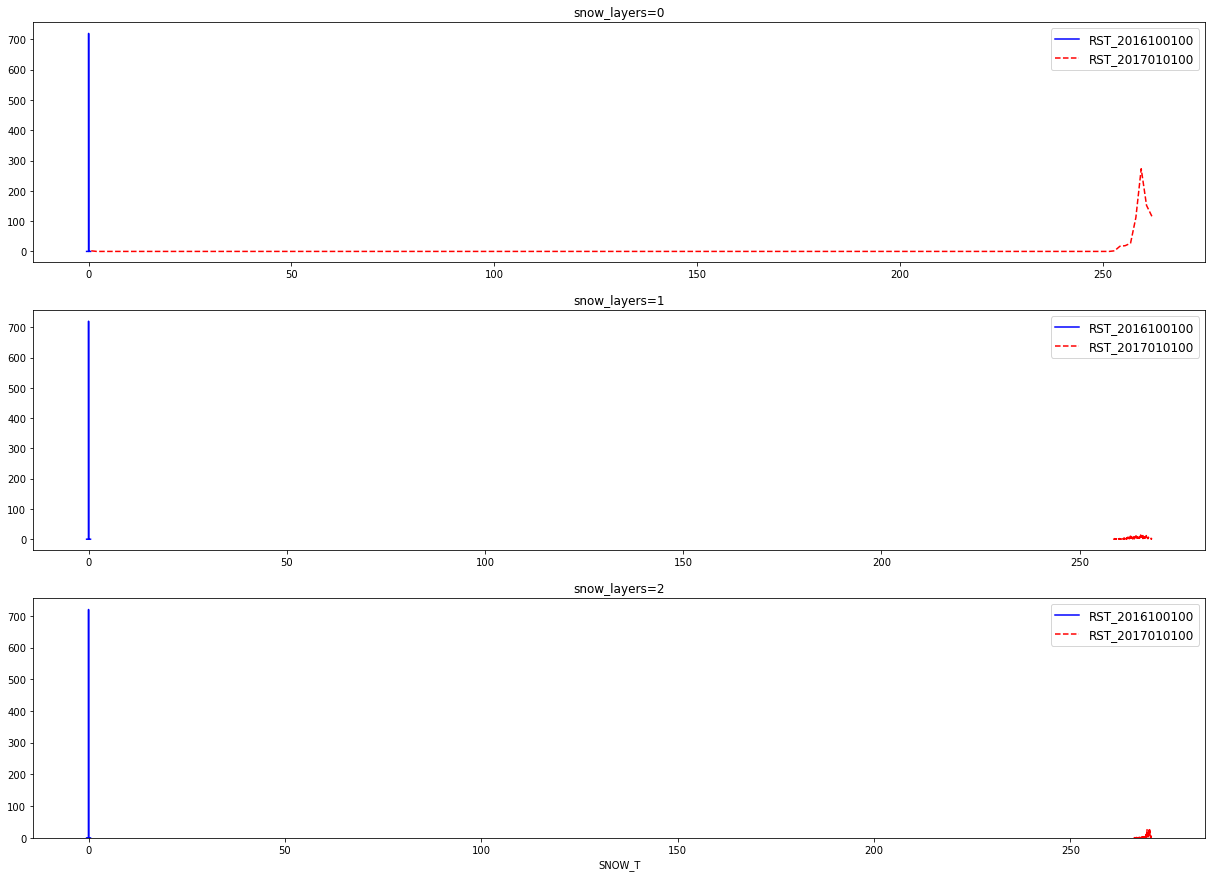

In [85]:
%%time
n_dims = len(plot_dims_sizes)
for j in range(n_dims):
    n_rows = plot_dims_sizes[j]
    fig, axs = plt.subplots(n_rows, 1, figsize=(21,5*n_rows), squeeze=False)
    for i in range(n_rows):
        n,x,_ = var1.isel({plot_dims[j]:i}).plot.hist(bins = 200, alpha=0)
        bin_centers = 0.5*(x[1:]+x[:-1])
        axs[i,j].plot(bin_centers,n, label=name1, color='blue')
        n,x,_ = var2.isel({plot_dims[j]:i}).plot.hist(bins = 200, alpha=0)
        bin_centers = 0.5*(x[1:]+x[:-1])
        axs[i,j].plot(bin_centers,n, label=name2, color='red', linestyle='dashed')
        axs[i,j].legend(loc='upper right', prop={'size': 12})
        axs[i,j].set_title(plot_dims[j]+'='+str(i))

CPU times: user 434 ms, sys: 0 ns, total: 434 ms
Wall time: 467 ms


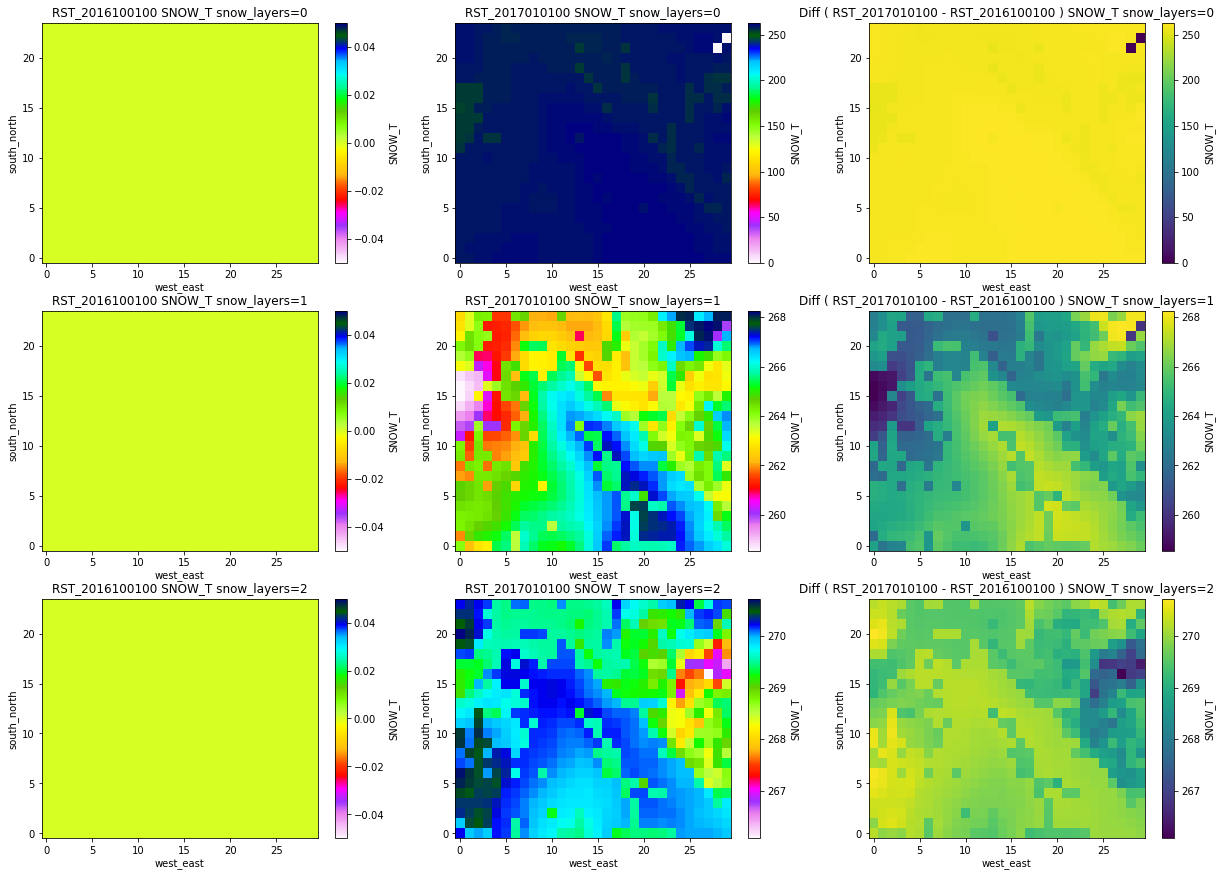

In [86]:
%%time
n_rows = plot_dims_sizes[0]
fig, axs = plt.subplots(n_rows,3,figsize=(21,5*n_rows), squeeze=False)
for i in range(n_rows):
    var1.isel({plot_dims[0]:i}).plot(ax=axs[i,0], cmap='gist_ncar_r')
    axs[i,0].set_title(name1+' '+var1.name+' '+plot_dims[j]+'='+str(i))
    var2.isel({plot_dims[0]:i}).plot(ax=axs[i,1], cmap='gist_ncar_r')
    axs[i,1].set_title(name2+' '+var2.name+' '+plot_dims[j]+'='+str(i))
    (var2-var1).isel({plot_dims[0]:i}).plot(ax=axs[i,2])
    axs[i,2].set_title('Diff ( '+name2+' - '+name1+' ) '+var2.name+' '+plot_dims[j]+'='+str(i))

